 # Cantilevered Beam with an Eccentric Mass - Tabletop Experiment
 
 We treat the cantilevered beam as a simple system with three degrees of freedom: two translational degrees and one rotational. 
 
 To compare the experimental results with the results from the FE simulations and the numerical solutions from an analytical model, we need to normalize the results, such that we remove the damping from the system. The generalized solution of a underdamped, harmonic oscillator reads as follows:
 
 $$ x = e^{-\gamma t} a cos(\omega t + \alpha) $$
 
 The overall data processing pipeline for the experimental data is as follows:
 
 1. read in raw data for each run and for each configuration
 2. find the first peak of each signal exceeding a load specific threshold to cut and align the time series data
     1. find max. acceleration for the fore-aft direction
     2. take the timestamp of the first maximum, substract one second
     3. substract this value from all other timestamps, effectively resetting it to epoch = 0     
 3. filter and integrate (acceleration)
     1. apply a high-pass filter to the acceleration
     2. integrate to yield velocity
     3. apply a high-pass filter
     4. integrate to yield poistion
     5. (optional) apply a high-pass filter again
 4. filter and integrate angular velcity
     1. apply a high pass filter to the angular velocity
     2. integrate angular velocity to yield the angle
 5. calculate the position of the eccentric mass as a new time series
 6. estimate the logarithmic decrement / damping factor and calculate an estimated decay curve for the position and the angle
 7. normalize the data with the estimate decay curve
 8. plot normalized orbits to compare to other systems
     
 

In [23]:
# pyhton imports needed for posprocessing the data
import json                                    # raw data is in json format
import pandas                                  # we will use pandas DataFrames to store and process data
import matplotlib.pyplot as plt                # used for building figures
import numpy as np                             # needed for fast math functions
from collections import namedtuple             # still needed?
from os import path                            # used to deal with paths under different operating systems
from glob import glob                          # Used to fuzzy find data files
from matplotlib.lines import Line2D as mlines  # needed to build custom legends
import matplotlib.dates as mdates

from scipy import integrate                    # to integrate time series
from scipy.signal import butter, lfilter, sosfiltfilt, filtfilt  # to built filters

from scipy.signal import find_peaks            # used to find peaks in the observed oscillations to estimate damping and decay curve

plt.style.use('publication')                   # sets legend, fonts, fontsize, etcdef find_maximum_timestamp(df, threshold=0.3, plot=True):


# needed to make plots interactive
%matplotlib notebook                          

g = 9.81

Fs = 50                                        # resampled data frequency
resample_dt = f'{(1/Fs)*1000}ms'               # resample string needed for pandas resample

experiments = dict()                           # used to store experimental data

data_dir = '../../data/experiment/'            # where the data is currently stored
results_dir = '../../results/experiment/'      # where to store results (plots, etc)

In [32]:
class DampedAmplitude():
    def __init__(self, A, gamma, t, offset):
        self._A = A
        self._gamma = gamma
        self._t = t
        self._offset = offset
        
        self._amplitude = self._A * np.power(np.e, self._gamma * self._t) + self._offset
        
    @property
    def amplitude(self):
        return self._amplitude

   
    @property
    def datetime(self):
        return pd.to_datetime(self._t, unit='s', utc=True)
    
def butter_highpass_sosfiltfilt(data, lowcut=0.1, fs=Fs, pad='even', padlen=500, order=9):
    """
    applies a symmetric filter (no phase offset)
    """

    if pad not in ('even', 'odd', 'constant', None):
        raise Exception('please provide a valid padding')

    # check if len(data > padlen)
    if len(data) < padlen:
        print(
            f'padlen exceeds the number of available data points. Setting padlen to {len(data)}')
        padlen = len(data) - 1

    nyq = fs*0.5
    low = lowcut/nyq

    sos = butter(order, low, btype='highpass', output='sos')
    y = sosfiltfilt(sos, data, padtype=pad, padlen=padlen)

    return y

def integrate_acc(df):
    
    t = df.index.astype('int64')/1e9
    
    for component in ['x', 'y', 'z']:
        df.insert(loc=len(df.columns),
                    value=integrate.cumtrapz(
                        df[f'acc_{component}'], t, initial=0),
                    column=f'vel_{component}',
                    )
    
    # apply a highpass filter to all components
    for c in ['vel_x', 'vel_y', 'vel_z']:
        df[c] = butter_highpass_sosfiltfilt(df[c], lowcut=0.5)
    import matplotlib.dates as mdates
    # integrate again
    for component in ['x', 'y', 'z']:
        df.insert(loc=len(df.columns),
                    value=integrate.cumtrapz(
                        df[f'vel_{component}'], t, initial=0),
                    column=f'pos_{component}',
                    )
        
    # apply a highpass filter to all components
    for c in ['pos_x', 'pos_y', 'pos_z']:
        df[c] = butter_highpass_sosfiltfilt(df[c], lowcut=0.5)
        
    return df
       
    
def integrate_rot(df):
    
    t = df.index.astype('int64')/1e9
    
    for component in ['x', 'y', 'z']:
        df.insert(loc=len(df.columns),
                    value=integrate.cumtrapz(
                        df[f'rot_{component}'], t, initial=0),
                    column=f'ang_{component}',
                    )
    # apply a highpass filter to all components
    for c in ['ang_x', 'ang_y', 'ang_z']:
        df[c] = butter_highpass_sosfiltfilt(df[c])
        
    return df
    
def find_maximum_timestamp(df, threshold=3, plot=True, offset=20):
    first_maximum_acc_y = find_peaks(df.acc_y.abs(), height=threshold)[0][0]
    start = df.index[first_maximum_acc_y - offset]
    
    if plot:
        plt.figure()
        plt.plot(df.acc_y)
        plt.scatter(df.index[first_maximum_acc_y], df.acc_y.iloc[first_maximum_acc_y], marker='x', s=50, color='tab:orange')
        plt.scatter(start, df.acc_y[start], marker = 'x', s=50, color='tab:red')
    
    return start
    t = data.index.astype('int64')/1e9
    

def reset_index(df, duration=pd.to_timedelta('2m'), plot=True):
    start = find_maximum_timestamp(df, plot=plot, offset=5)
    end = start + duration
    
    df = df[start:end]    
    df.index = pd.to_datetime(0, unit='s', utc=True) + (df.index - start)
    return df

def plot_acc(data : list, fitted_amplitude : DampedAmplitude, savepath = '/tmp/bla.png'):

    fig, (ax1, ax2, ax3) = plt.subplots(sharey=False, sharex=True, nrows=3, figsize=(9,9))
    #ax1_2 = ax1.twinx()
    ax1.plot(data[0].acc_x)
    ax1.plot(data[0].acc_y)
    ax1.plot(data[1].acc_x)
    ax1.plot(data[1].acc_y)
    ax1.plot(data[2].acc_x)
    ax1.plot(data[2].acc_y)
    ax1.plot(fitted_amplitude.datetime, fitted_amplitude.amplitude, color='grey')

    ax1.set_ylabel('acceleration ($m s^{-2}$)')
    
    ax2.plot(data[0].rot_z, color='tab:red')
    ax2.plot(data[1].rot_z, color='tab:red')
    ax2.plot(data[2].rot_z, color='tab:red')
    
    ax2.set_ylabel('angular velocity ($deg s^{-1}$)')

    ax3.plot(data[0].acc_abs_xy)

    ax3.plot(data[1].acc_abs_xy)
    ax3.plot(data[2].acc_abs_xy)
    ax3.plot(fitted_amplitude.datetime, fitted_amplitude.amplitude, color='grey')
    
    ax3.set_ylabel('abs. acceleration ($m s^{-2}$)')
    
    ax3.set_xlabel('time (s)')
    
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))
    ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%M:%S"))
    _=plt.xticks(rotation=45) 
    
    fig.tight_layout()

    try:
        plt.savefig(savepath, dpi=300)
    except Exception as e:
        print(f'failed to export graphic: {e}')
    
def plot_acc_normalized(data : list, fitted_amplitude : DampedAmplitude):
    fig, (ax1, ax2) = plt.subplots(sharey=False, sharex=True, nrows=2)
    #ax1_2 = ax1.twinx()
    ax1.plot(data[0].acc_x)
    ax1.plot(data[0].acc_y)
    ax1.plot(data[1].acc_x)
    ax1.plot(data[1].acc_y)
    ax1.plot(data[2].acc_x)
    ax1.plot(data[2].acc_y)
    ax1.plot(t_i, fitted_amplitude.amplitude, color='grey')
    ax1.grid()

    ax2.plot(data[0].acc_x/fitted_amplitude.amplitude)
    ax2.plot(data[0].acc_y/fitted_amplitude.amplitude)
    ax2.plot(data[1].acc_x/fitted_amplitude.amplitude)
    ax2.plot(data[1].acc_y/fitted_amplitude.amplitude)
    ax2.plot(data[2].acc_x/fitted_amplitude.amplitude)
    ax2.plot(data[2].acc_y/fitted_amplitude.amplitude)
    ax2.grid()

    fig.tight_layout()
    
    try:
        plt.savefig(savepath, dpi=300)
    except Exception as e:
        print(f'failed to export graphic: {e}')

def plot_orbit(data : list, fitted_amplitude : DampedAmplitude, end = pd.to_datetime('1970-01-01 00:00:30'), savepath='/tmp/bla.png'):

    plt.figure(figsize=(9, 9))
    plt.plot((data[0].pos_x/fitted_amplitude.amplitude)[:end], (data[0].pos_y/fitted_amplitude.amplitude)[:end])
    plt.plot((data[1].pos_x/fitted_amplitude.amplitude)[:end], (data[1].pos_y/fitted_amplitude.amplitude)[:end])
    plt.plot((data[2].pos_x/fitted_amplitude.amplitude)[:end], (data[2].pos_y/fitted_amplitude.amplitude)[:end])
    plt.axis('equal')
    
    plt.xlabel('side-side')
    plt.ylabel('fore-aft')
    
    plt.tight_layout()
    
    try:
        plt.savefig(savepath, dpi=300)
    except Exception as e:
        print(f'failed to export graphic: {e}')

In [30]:
# main logic to read in experimental data
for directory in sorted(glob(path.join(data_dir, '10-cm_?-screws'))):          # we only postprocess experimental data, where the initial offset was 10 cm
    key = directory.split('_')[1]                                              # key to identify data subset in the dictionary
    print (f'data key: {key}')
    experiments[key] = list()
    
    for data_file in glob(path.join(directory, '*.json')):                     # find each json file in the directory and iterate over it
        print(data_file)
        with open(data_file, 'r') as data_file_handler:                        # open the json file
            data = list()                                                      # to temporary store data
            
            for i, line in enumerate(data_file_handler.readlines()):                         # read each line
                try:
                    data.append(json.loads(line))                              # and try to convert it from json into a valid dictionary
                except:
                    print(f'failed to parse json in file {data_file} line {i}')  # skip, if failed
                    
            # the raw data is now stored in a list, where each line is a valid dict holding the measurement.
            # we now extract the timestamp, linear acceleration and angular velocity and convert it into a DataFrame
            data_df = pd.DataFrame(
                [[d['timestamp'],                      # Unix epoch + millisecond accuracy
                  d['linear_acceleration']['x'] * g,       # side-side acceleration in the local reference frame, unit is g (9.81 m/s/s)
                  d['linear_acceleration']['y'] * g,       # fore-aft acceleration in the local reference frame, unit is g as well 
                  d['linear_acceleration']['z'] * g,       # acceleration in rod normal direction, positive is downwards 
                  d['rotational_acceleration']['x'],   # pitch-rate
                  d['rotational_acceleration']['y'],   # roll-rate
                  d['rotational_acceleration']['z']] for d in data], # yaw-rate
                columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z']
            )
            
            data_df.timestamp = pd.to_datetime(data_df.timestamp, unit='s', utc=True)     # convert the timestamp into a valid python DateTime object
            data_df.set_index('timestamp', inplace=True)                                  # create a time index for the data frame
            data_df.sort_index(inplace=True)                                              # in case the data is not temporally sorted
            data_df = data_df[~data_df.index.duplicated(keep='first')]                    # remove duplicated indices if any
            data_df = data_df.resample(resample_dt).ffill()[1:]                           # resample data to Fs (nominaly 50 Hz)
            
            data_df = reset_index(data_df, plot=False)
            
            for c in data_df.columns:
                data_df[c] = butter_highpass_sosfiltfilt(data_df[c])
            
            data_df = integrate_acc(data_df)
            data_df = integrate_rot(data_df)
                      
            # calculate the absolute acceleration in the xy-plane
            data_df.insert(loc=len(data_df.columns), 
                           value=np.sqrt(np.power(data_df.acc_x, 2) + np.power(data_df.acc_y, 2)), 
                           column='acc_abs_xy'
                          )
            
            # calculate the absolute acceleration in the xy-plane
            data_df.insert(loc=len(data_df.columns), 
                           value=np.sqrt(np.power(data_df.pos_x, 2) + np.power(data_df.pos_y, 2)), 
                           column='pos_abs_xy'
                          )
            
            experiments[key].append(data_df)

data key: 0-screws
../../data/experiment/10-cm_0-screws/mass-eccentricity_2021-07-dT23-19-35+0200.json
../../data/experiment/10-cm_0-screws/mass-eccentricity_2021-07-dT23-29-04+0200.json
../../data/experiment/10-cm_0-screws/mass-eccentricity_2021-07-dT23-24-10+0200.json
data key: 2-screws
../../data/experiment/10-cm_2-screws/mass-eccentricity_2021-07-dT22-50-37+0200.json
../../data/experiment/10-cm_2-screws/mass-eccentricity_2021-07-dT22-45-05+0200.json
../../data/experiment/10-cm_2-screws/mass-eccentricity_2021-07-dT22-39-26+0200.json
data key: 4-screws
../../data/experiment/10-cm_4-screws/mass-eccentricity_2021-07-dT23-07-42+0200.json
../../data/experiment/10-cm_4-screws/mass-eccentricity_2021-07-dT23-03-18+0200.json
../../data/experiment/10-cm_4-screws/mass-eccentricity_2021-07-dT23-12-37+0200.json


## Estimated Amplitudes

To compare the tabletop experiments with FE-Simulations and the results obtained from solving differential equations, we need to get rid of the damping in the system. To do so, we estimate the observed, decaying amplitude in the experimental data with an exponential function and normalize the observed accelerations with said function:

$$
a(t)_{undamped} = \frac{a(t)_{damped}}{A e ^ {- \gamma t} + a}
$$

Where $A_0$, $\gamma$ and $a$ need to be estimated from the observed data

---

For the measured accelerations the parameters are estimated as follows:

| configuration | $A$   | $\gamma$ | $a$ |
|---------------|-------|----------|-----|
| low mass      | XX    | XX       | XX  |
| medium mass   | 7.5   | -0.06    | 0.05|
| high mass     | XX    | XX       | XX  |

---

For the displacement, the following amplitudes were estimated

| configuration | $A$   | $\gamma$ | $a$ |
|---------------|-------|----------|-----|
| low mass      | XX    | XX       | XX  |
| medium mass   | 7.5   | -0.06    | 0.05|
| high mass     | XX    | XX       | XX  |

<IPython.core.display.Javascript object>


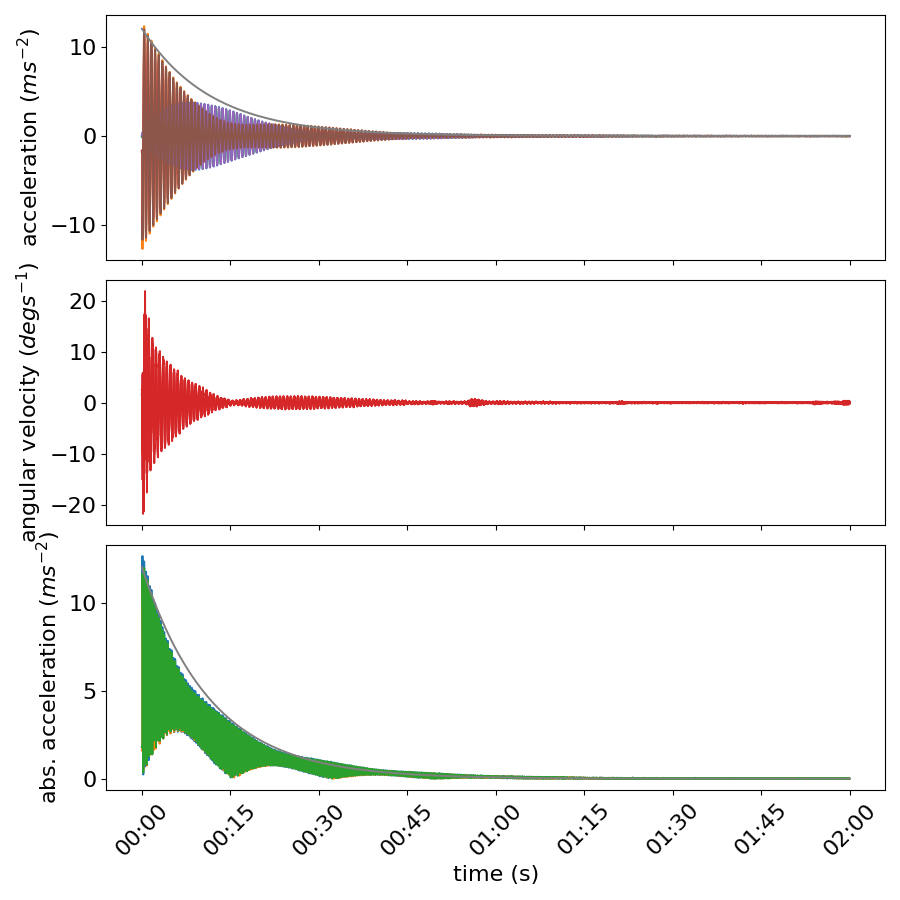

<IPython.core.display.Javascript object>


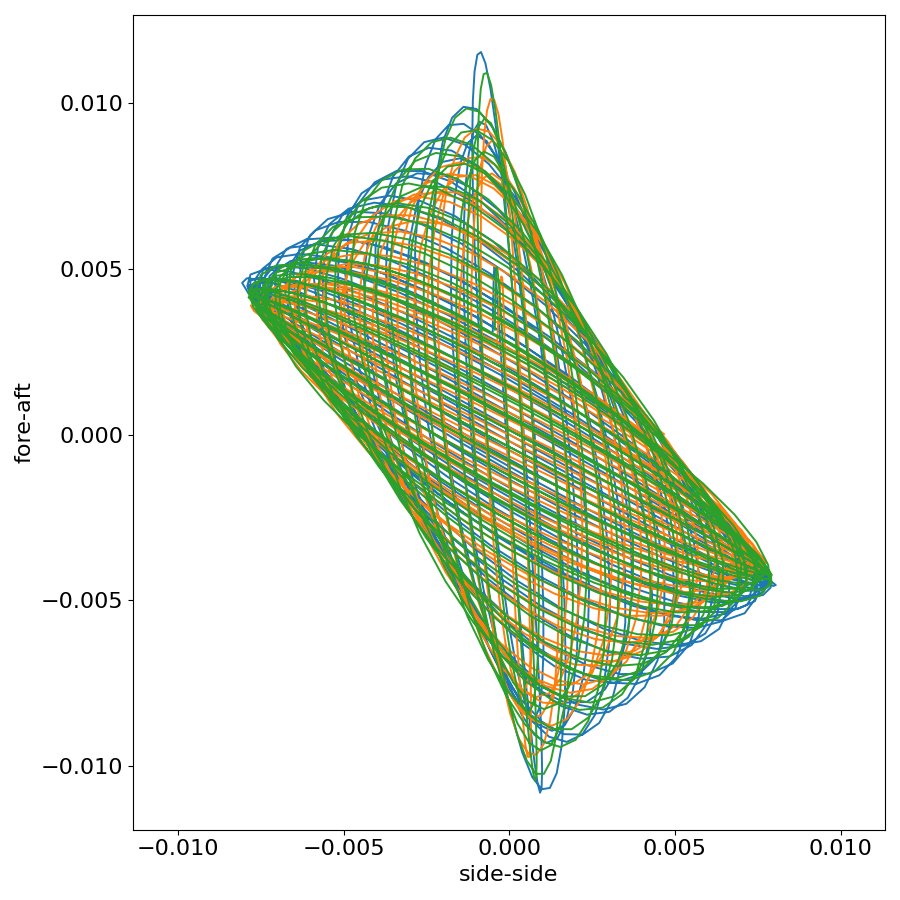

In [33]:
d0 = experiments['0-screws']

low_mass_amplitude = DampedAmplitude(A = 12, gamma = -0.085, t = t, offset = 0.01)

plot_acc(d0, low_mass_amplitude, path.join(results_dir, 'low_mass_acceleration.png'))
plot_orbit(d0, low_mass_amplitude, pd.to_datetime('1970-01-01 00:00:20'), path.join(results_dir, 'low_mass_orbit.png'))

<IPython.core.display.Javascript object>


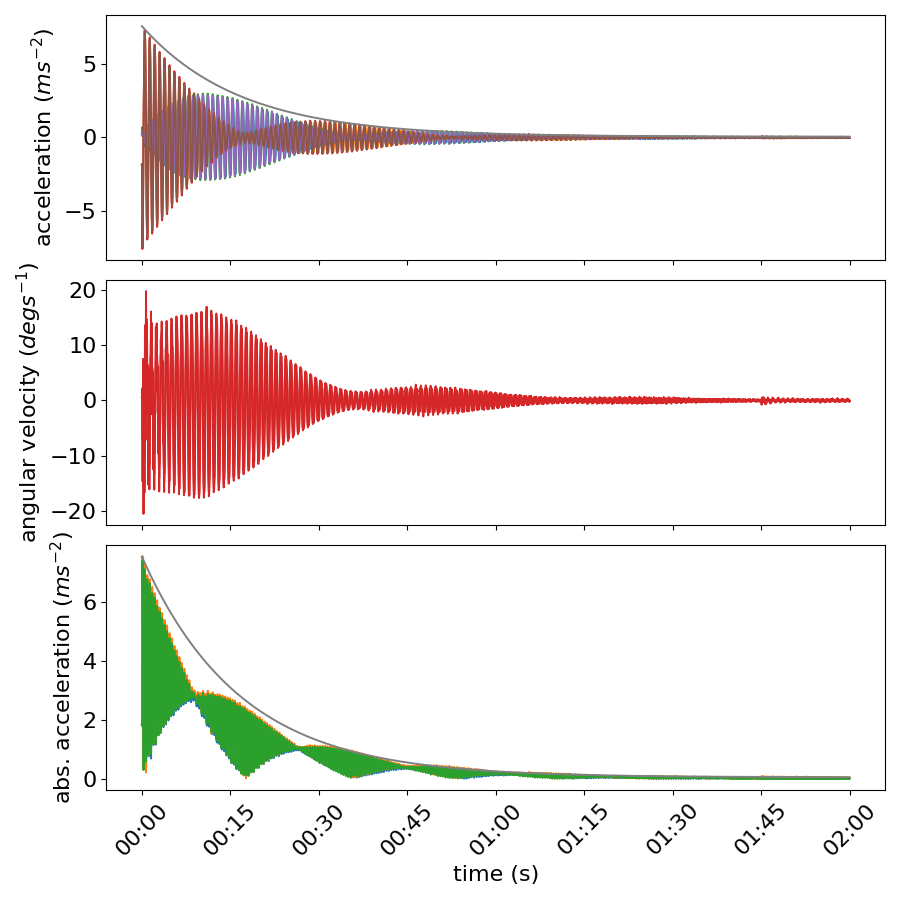

<IPython.core.display.Javascript object>


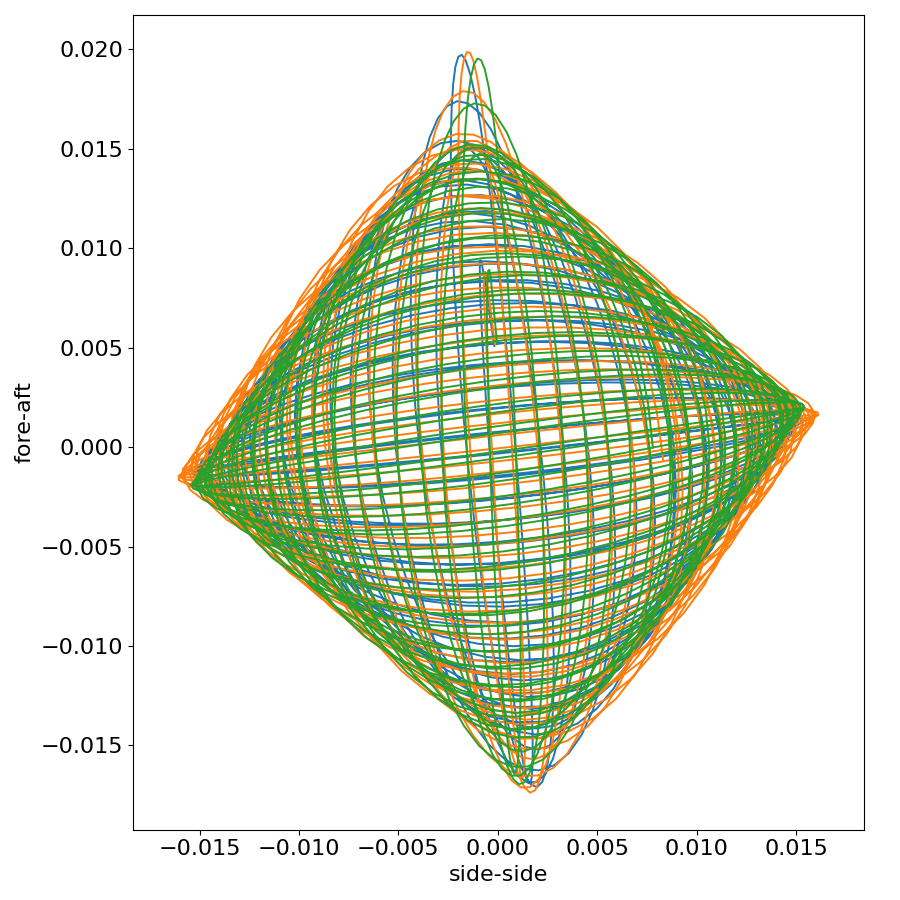

In [34]:
t = np.linspace(0, 120, 6001)
d2 = experiments['2-screws']

medium_mass_amplitude = DampedAmplitude(A = 7.5, gamma = -0.06, t = t, offset = 0.05)

plot_acc(d2, medium_mass_amplitude, path.join(results_dir, 'medium_mass_acceleration.png'))
plot_orbit(d2, medium_mass_amplitude, pd.to_datetime('1970-01-01 00:00:30'), path.join(results_dir, 'medium_mass_orbit.png'))

<IPython.core.display.Javascript object>


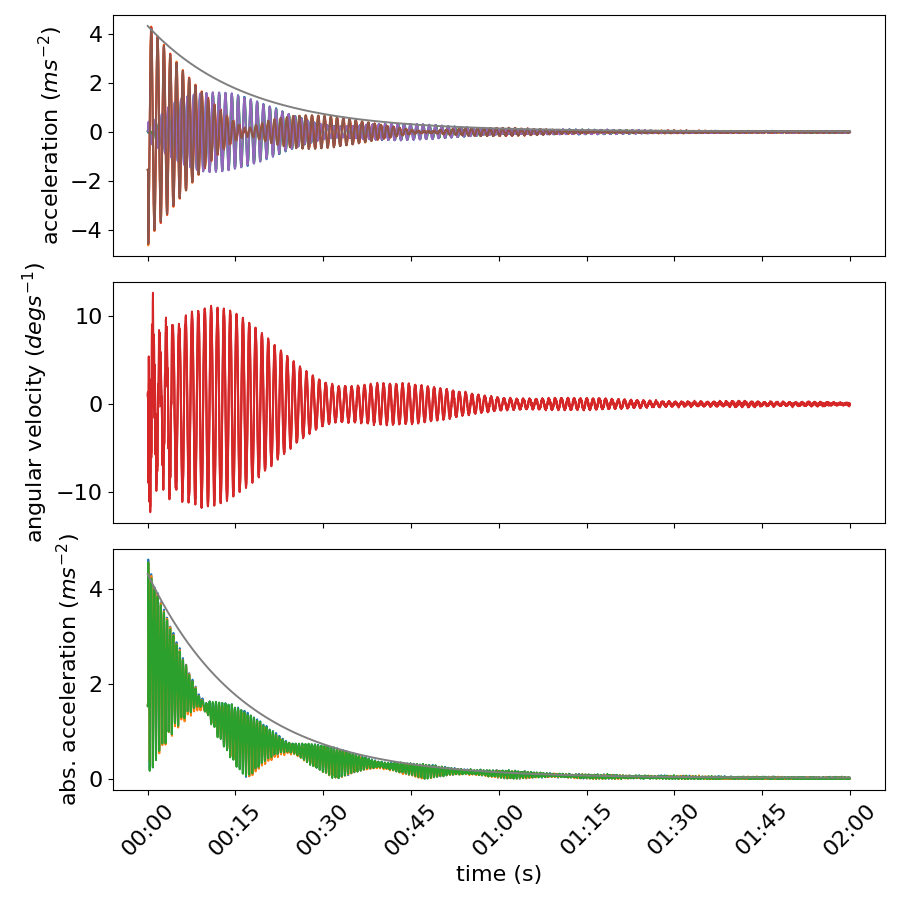

<IPython.core.display.Javascript object>


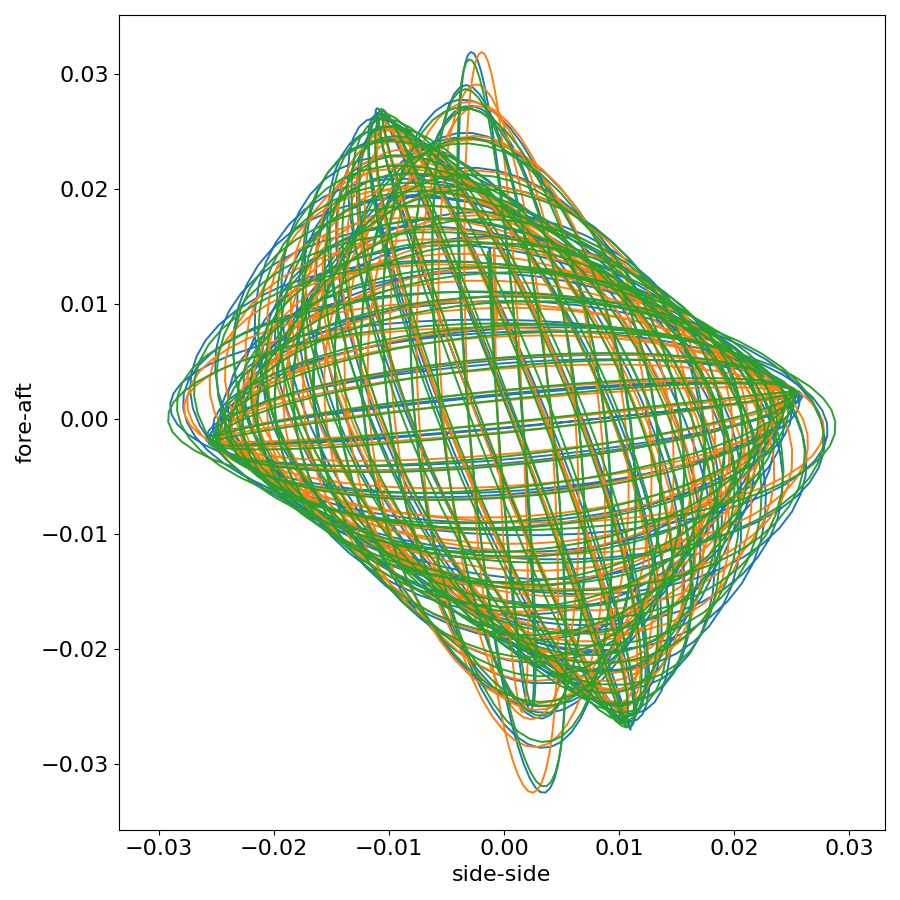

In [35]:
t = np.linspace(0, 120, 6001)
d4 = experiments['4-screws']

high_mass_amplitude = DampedAmplitude(A = 4.3, gamma = -0.06, t = t, offset = 0.025)

plot_acc(d4, high_mass_amplitude, path.join(results_dir, 'high_mass_acceleration.png'))
plot_orbit(d4, high_mass_amplitude,pd.to_datetime('1970-01-01 00:00:45'), path.join(results_dir, 'high_mass_orbit.png'))

<IPython.core.display.Javascript object>


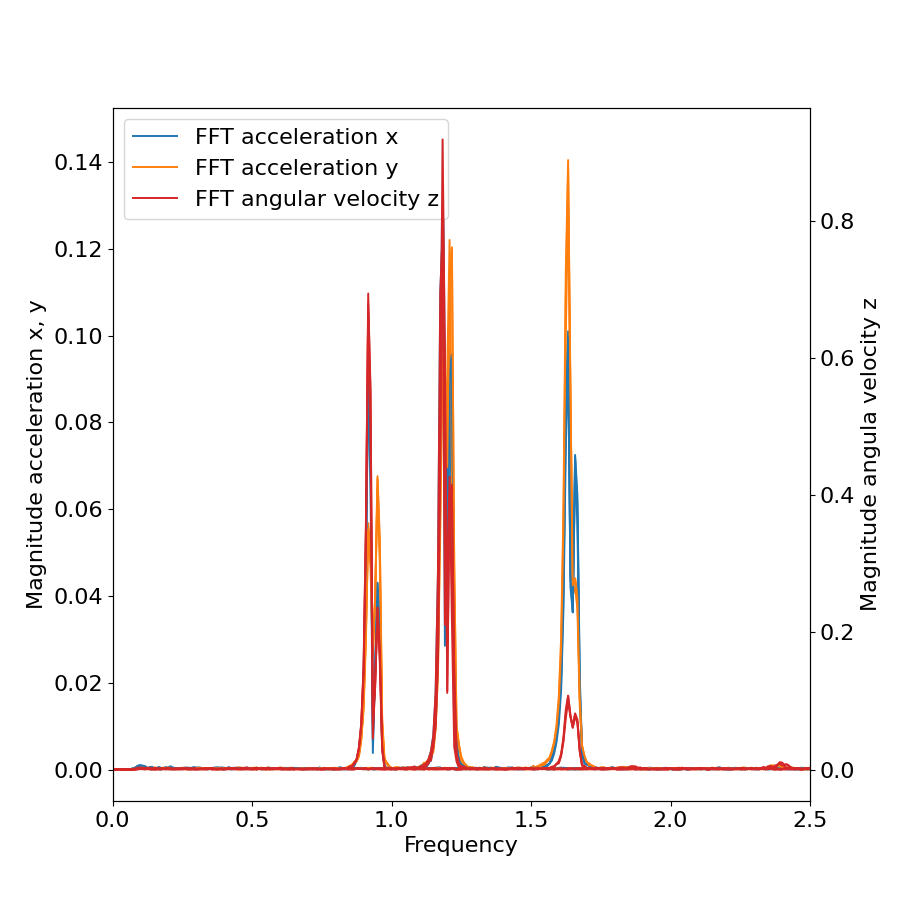

In [496]:
fig = plt.figure(figsize=(9, 9))
ax1 = plt.gca()
ax2 = plt.gca().twinx()
for key, data_l in experiments.items():
    for df in data_l:
        
        ax2.magnitude_spectrum(df.rot_z, Fs=Fs, color='tab:red')
        
        ax1.magnitude_spectrum(df.acc_x, Fs=Fs, color='tab:blue')
        ax1.magnitude_spectrum(df.acc_y, Fs=Fs, color='tab:orange')
                
ax1.set_xlim([0, 2.5])
ax1.set_ylabel('Magnitude acceleration x, y')
ax2.set_ylabel('Magnitude angula velocity z')
        
ax1.legend(handles = [mlines([0], [0], color='tab:blue', label='FFT acceleration x'), mlines([0], [0], color='tab:orange' , label='FFT acceleration y'), mlines([0], [0], color='tab:red', label='FFT angular velocity z')])


fig.savefig(path.join(results_dir, 'spectrum.png'))